<a href="https://colab.research.google.com/github/nawroz-m/ML_learning/blob/main/06_Transfer_learning_Internsorflow_Scalling_UP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this part the goal is to beat the original food101 paper with 10% of the training dataset(Leveraging the power of deep learning)
Our baseline to beat is 50.76% accuracy across all 101 classes


In [9]:
# Download the 10% of 101 classe datasets
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-11-17 15:24:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.207, 64.233.189.207, 108.177.97.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  29.5MB/s    in 55s     

2025-11-17 15:25:52 (28.4 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplt
import pathlib
import numpy as np
import random
import tensorflow as tf
import datetime
import pandas as pd

In [10]:
# unzip the downloaded dataset
zip_ref = zipfile.ZipFile('101_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [11]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [ ]:
# walk through all the dataset file and folder
for dirpath, dirnames, filenames in os.walk('101_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}')

There are 2 directories and 0 files in 101_food_classes_10_percent
There are 101 directories and 0 files in 101_food_classes_10_percent/test
There are 0 directories and 250 files in 101_food_classes_10_percent/test/baby_back_ribs
There are 0 directories and 250 files in 101_food_classes_10_percent/test/chicken_quesadilla
There are 0 directories and 250 files in 101_food_classes_10_percent/test/dumplings
There are 0 directories and 250 files in 101_food_classes_10_percent/test/apple_pie
There are 0 directories and 250 files in 101_food_classes_10_percent/test/tiramisu
There are 0 directories and 250 files in 101_food_classes_10_percent/test/mussels
There are 0 directories and 250 files in 101_food_classes_10_percent/test/ceviche
There are 0 directories and 250 files in 101_food_classes_10_percent/test/peking_duck
There are 0 directories and 250 files in 101_food_classes_10_percent/test/crab_cakes
There are 0 directories and 250 files in 101_food_classes_10_percent/test/chicken_curry
The

In [12]:
# get all the classes
class_path = pathlib.Path(train_dir)
class_names = np.array(sorted(item.name for item in class_path.glob('*')))


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

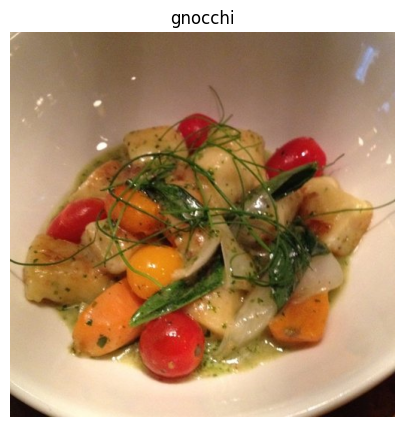

In [13]:
# Visualize a ranodm training dataset
# pick a random class
random_class = random.choice(class_names)
# list all the images within the slected class
image_dir = os.path.join(train_dir, random_class)
# list all the images in the directory
images = os.listdir(image_dir)
# pick a random image
random_image = random.choice(images)
# get the decode image with matplot
img = mplt.imread(os.path.join(image_dir, random_image))
# plot the image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title(random_class)
plt.axis(False)


In [15]:
# Setup data inputs
IMAGE_SIZE=(224, 224)
train_data_10_percent = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                    label_mode='categorical',
                                                                    batch_size=32,
                                                                    image_size=IMAGE_SIZE,
                                                                    shuffle=True,
                                                                    seed=42)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           label_mode='categorical',
                                                           batch_size=32,
                                                           image_size=IMAGE_SIZE,
                                                           shuffle=False, # don't shuffle the test data for prediction analysis
                                                           seed=42)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
len(train_data_10_percent), 7575/32

(237, 236.71875)

In [9]:
# look through images and label of training dataset
train_iter = iter(train_data_10_percent)
images, labels = next(train_iter)

In [10]:
labels[0].shape, images[0].shape

(TensorShape([101]), TensorShape([224, 224, 3]))

## Train the big mode model with 10% dataset of 101 food classes
Here are the steps we're going to take:
* Create a model checkpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless(no top layers) functional EfficientnetB0 backbond-model(We'll create our own ouput)
* Compile the model
* Feature extract for 5 full pass(5 ecpochs on train dataset and valid on 15% of test data, to save epoch time)

In [11]:
# Chreate a model checkpoint callback
base_epoch = 5
checkpoint_filepath = 'ckpt/checkpoint.weights.h5'
create_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                             monitor='val_accuracy',
                                                             verbose=1,
                                                             save_weights_only=True,
                                                             save_freq='epoch',
                                                             save_best_only=True)

In [12]:
# Create a data augmentation layer to build the data augmentation right on the model
augmented_layers = tf.keras.Sequential([
    # tf.keras.layers.Input(shape=IMAGE_SIZE+(3,)),
    tf.keras.layers.RandomShear((0.0, 0.2)),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    # tf.keras.layers.RandomFlip(mode='horizontal'),
    # tf.keras.layers.Rescaling(1/255.)
], name='data_augmentation_layer')

(np.float64(-0.5), np.float64(255.5), np.float64(181.5), np.float64(-0.5))

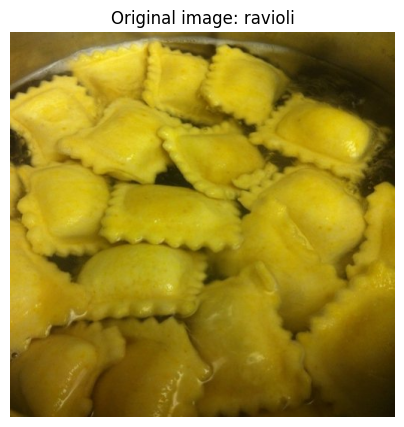

<Figure size 640x480 with 0 Axes>

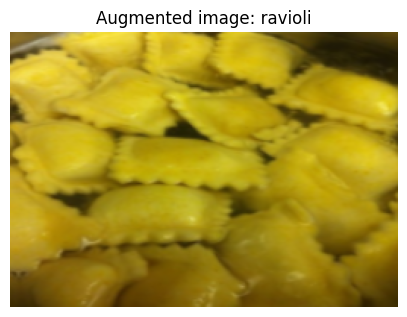

In [ ]:
# Plot a random augmented iamge
random_class = random.choice(class_names)
# create iamge directory
image_dir = os.path.join(train_dir, random_class)
# list all the images in the directory
images = os.listdir(image_dir)
# pick a random image
random_image = random.choice(images)
# reade the image
image = mplt.imread(os.path.join(image_dir, random_image))

# Plot the original image
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.title(f'Original image: {random_class}')
plt.axis(False)
plt.figure()

#Plot the augmented image
reshaped_image = tf.image.resize(image, size=IMAGE_SIZE)
expand_dim = tf.expand_dims(reshaped_image, axis=0)
aug_image = augmented_layers(expand_dim)

plt.figure(figsize=(5,5))
plt.imshow(aug_image[0])
plt.title(f'Augmented image: {random_class}')
plt.axis(False)

In [13]:
# Create a tensorflow tesnsorboard callback
def create_tensorboard_callback(dir_path, experiment):
  currenttime = datetime.datetime.now()
  date_string = currenttime.strftime('%Y-%m-%d-%H-%M-%S')
  return tf.keras.callbacks.TensorBoard(os.path.join(dir_path, experiment, date_string))

In [14]:
# Build a headless model EfficientnetB0 backboned
# get the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# frezz the base model to make sure the layer remain un change while training
base_model.trainable = False
# Create an input layer to the model
inputs = tf.keras.layers.Input(shape=IMAGE_SIZE+(3,), name='Input_layer')
# Add the data augmentation layer on the model
x = augmented_layers(inputs)
# Add inputs to the base model
x = base_model(x, training=False)
print(f'The layer shape after adding base model {x.shape}')
# Add a global Average pooling 2D to the layer to make the base_model output is compatibale with new one
x = tf.keras.layers.GlobalAveragePooling2D()(x)
print(f'The layer shape after adding GlobalAveragePooling2D {x.shape}')
# Create an outputs
outputs = tf.keras.layers.Dense(len(class_names), activation=tf.keras.activations.softmax,
                                name='Output_layer')(x)
# build the headless model
model_0 = tf.keras.Model(inputs=inputs, outputs=outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
The layer shape after adding base model (None, None, None, 1280)
The layer shape after adding GlobalAveragePooling2D (None, 1280)


In [15]:
model_0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_layer         │ (None, None, None, 3)  │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [16]:
for layer_num, layer in enumerate(model_0.layers):
  print(layer_num, layer.name, layer.trainable, len(layer.trainable_variables))

0 Input_layer True 0
1 data_augmentation_layer True 0
2 efficientnetb0 False 0
3 global_average_pooling2d True 0
4 Output_layer True 2


In [17]:
# Compile the model
model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [18]:
# Train the model for 5 epoch and 15% of validation data
base_epoch=5
history_0 = model_0.fit(train_data_10_percent,
                        epochs=base_epoch,
                        callbacks=[create_model_checkpoint],
                        validation_data=test_data,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_steps= int(0.10 * len(test_data))) # validate on 15% of data to mek faster training

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.1701 - loss: 3.9137
Epoch 1: val_accuracy improved from -inf to 0.45411, saving model to ckpt/checkpoint.weights.h5
237/237 ━━━━━━━━━━━━━━━━━━━━ 54s 162ms/step - accuracy: 0.1706 - loss: 3.9112 - val_accuracy: 0.4541 - val_loss: 2.4913
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5173 - loss: 2.1866
Epoch 2: val_accuracy improved from 0.45411 to 0.50910, saving model to ckpt/checkpoint.weights.h5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 146ms/step - accuracy: 0.5173 - loss: 2.1863 - val_accuracy: 0.5091 - val_loss: 2.0338
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5971 - loss: 1.7398
Epoch 3: val_accuracy improved from 0.50910 to 0.51622, saving model to ckpt/checkpoint.weights.h5
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 147ms/step - accuracy: 0.5971 - loss: 1.7397 - val_accuracy: 0.5162 - val_loss: 1.8864
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6413 - loss: 1.512

<Axes: >

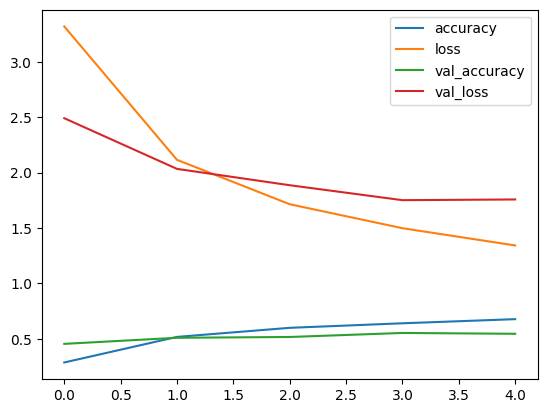

In [19]:
pd.DataFrame(history_0.history).plot()

In [20]:
# Evaluate on the whole test data
model_0_eval_result = model_0.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.5659 - loss: 1.6574


In [21]:
model_0_eval_result

[1.5323878526687622, 0.5944158434867859]

*We are already beating the orignal paper of 101 food vision whic is (50.76%)*

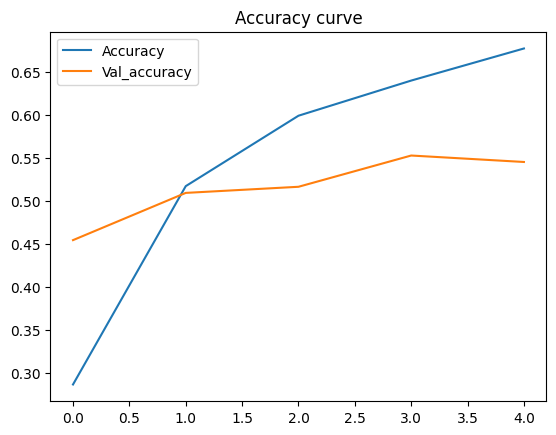

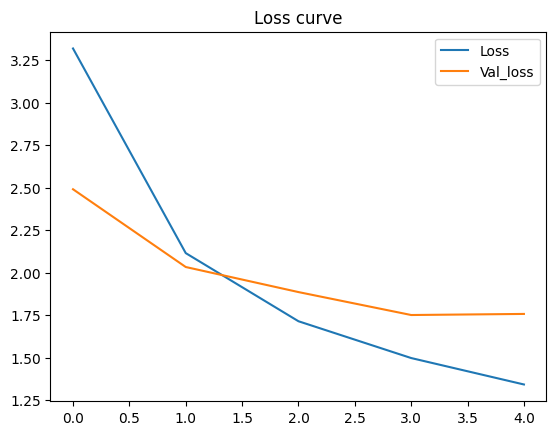

In [22]:
# Plot the history graph each suprately
accuracy = history_0.history['accuracy']
val_accuracy = history_0.history['val_accuracy']
loss = history_0.history['loss']
val_loss = history_0.history['val_loss']
epochs = range(len(history_0.history['accuracy']))
# plot the accuracy curve
plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, val_accuracy, label='Val_accuracy')
plt.title('Accuracy curve')
plt.legend()
plt.figure()
# Plot the loss curve
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, label='Val_loss')
plt.title('Loss curve')
plt.legend()

As the graph sugest our model is overfitting(performing too well on training data and not generalizing on unseen(test) data)
> 🔑 **Note:** There are many ways to improve overfitting but let's start with ***Fine-tuning*** if it helps overfitting

# Fine-tuning

In [23]:
# let's unfrezz the top loayers
base_model.trainable = True
# Since our model is already doing prety well, I'll refrezz all layer except last 5
for layer in base_model.layers[:-5]: # We unfrozz the last or the bottom layer of basemodel, the reason is that in CNN the top layers
# include larger feature(pattern) so we need the most important features which are at the bottom of the layers
  layer.trainable = False


> We unfrozz the last or the bottom layer of basemodel, the reason is that in CNN the top layers include larger feature(pattern) so we need the most important features which are at the bottom of the layers. So that's why we select them for the `Fine-tuning` to slowley adjust to our own dataset and avoid overfitting

In [24]:
# Recompile the model_0 for fine-tuning with a lower learning rate
model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [25]:
# What layers are trainable
for layer in model_0.layers:
  print(layer.name, layer.trainable)

Input_layer True
data_augmentation_layer True
efficientnetb0 True
global_average_pooling2d True
Output_layer True


In [26]:
# Check which layers are trainable in the base_model
for layer in model_0.layers[2].layers:
  print(layer.name, layer.trainable)

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [27]:
history_0.epoch[-1]

4

In [28]:
# Fine-tuning the model
FINE_TUNING_EPOCH = base_epoch+5
history_0_fine_tuning = model_0.fit(train_data_10_percent,
                        epochs=FINE_TUNING_EPOCH,
                        validation_data=test_data,
                        validation_steps=int(0.15*(len(test_data))),
                        steps_per_epoch=len(train_data_10_percent),
                        initial_epoch=history_0.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.6904 - loss: 1.3079 - val_accuracy: 0.5742 - val_loss: 1.6443
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - accuracy: 0.7362 - loss: 1.1152 - val_accuracy: 0.5829 - val_loss: 1.6054
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step - accuracy: 0.7606 - loss: 1.0114 - val_accuracy: 0.5869 - val_loss: 1.5636
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.7797 - loss: 0.9269 - val_accuracy: 0.5908 - val_loss: 1.5437
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.7941 - loss: 0.8847 - val_accuracy: 0.5916 - val_loss: 1.5300
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step - accuracy: 0.8028 - loss: 0.8352 - val_accuracy: 0.5887 - val_loss: 1.5312


> 🔑 **Note:** Fine-tuning doesn't always improve the model result and that's why we setup the `checkpoint` if *fine-tuning* result terible we can revert back to the where we left off

<Axes: >

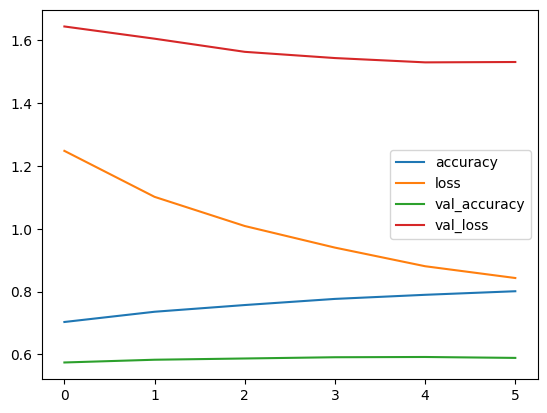

In [29]:
pd.DataFrame(history_0_fine_tuning.history).plot()

In [30]:
# Let's evaluate on the whole test dataset
model_0_eval_result_fine_tuning = model_0.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.6107 - loss: 1.4497


In [31]:
# Compare the feature extraction and fine_tuning result
model_0_eval_result, model_0_eval_result_fine_tuning

([1.5323878526687622, 0.5944158434867859],
 [1.3602001667022705, 0.6311683058738708])

In [32]:
history_0.history['accuracy']

[0.28607261180877686,
 0.5169637203216553,
 0.5989438891410828,
 0.6398679614067078,
 0.6772277355194092]

In [33]:
# Function to compare the orignal and the fine-tuned history
def compare_model_history(original_history, new_history, initial_epoch):
  # orignal history
  accuracy_orignal = original_history.history['accuracy']
  val_accuracy_orignal = original_history.history['val_accuracy']
  loss_orignal = original_history.history['loss']
  val_loss_orignal = original_history.history['val_loss']
  # new history
  accuracy_new = new_history.history['accuracy']
  val_accuracy_new = new_history.history['val_accuracy']
  loss_new = new_history.history['loss']
  val_loss_new = new_history.history['val_loss']

  # Total the history params for plot
  accuracy_total = accuracy_orignal + accuracy_new
  val_accuracy_total = val_accuracy_orignal + val_accuracy_new
  loss_total = loss_orignal + loss_new
  val_loss_total = val_loss_orignal + val_loss_new
  plt.plot(accuracy_total, label='Taining accuracy')
  plt.plot(val_accuracy_total, label='Training val_accuracy')
  plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label='Start fine-tuning')
  plt.legend()
  plt.figure()
  plt.plot(loss_total, label='Training loss')
  plt.plot(val_loss_total, label='Training val_loss')
  plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label='Start fine-tuning')
  plt.legend()

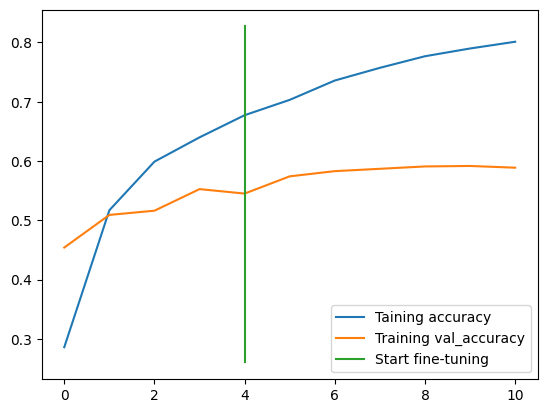

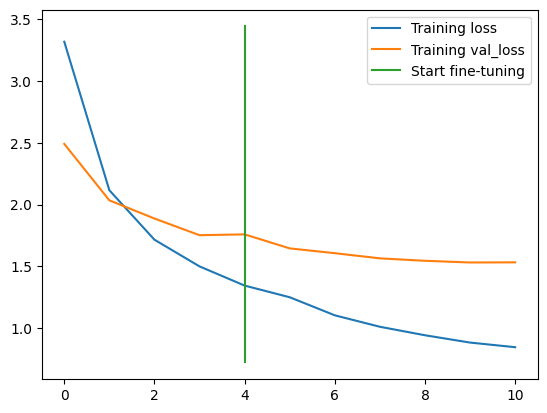

In [34]:
compare_model_history(history_0, history_0_fine_tuning, base_epoch)

> 🔑 **Note:** As in the graph shows it's still overfitting and the `fine-tuning` only improved the learning accuracy and the training loss. In order to aligne the `loss` and `val_loss` we must apply some overfitting techniqe

In [5]:
save_model_path = 'drive/MyDrive/Models/fine_tune_model.keras'


In [38]:
# Saving and loading our trained model
model_0.save(save_model_path, )

In [7]:
loaded_model = tf.keras.models.load_model(save_model_path)

In [8]:
loaded_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_layer         │ (None, None, None, 3)  │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,596 (22.89 MB)

 Trainable params: 910,821 (3.47 MB)

 Non-trainable params: 3,268,131 (12.47 MB)

 Optimizer params: 1,821,644 (6.95 MB)

In [42]:
# Evaluate the loaded model with test datasete
model_0_eval_result_fine_tuning_reloaded = loaded_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 77ms/step - accuracy: 0.6107 - loss: 1.4497


In [43]:
# Compare the original evaluation data with the reloaded one
model_0_eval_result_fine_tuning, model_0_eval_result_fine_tuning_reloaded

([1.3602001667022705, 0.6311683058738708],
 [1.3602001667022705, 0.6311683058738708])

# Evaluating the big dog model across all different classes
Let's make some prediction vesiualize them and latter find out which prediction ware the `most` wrong

In [44]:
fine_tuning_propbability = loaded_model.predict(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 64s 79ms/step


In [50]:
len(fine_tuning_propbability), fine_tuning_propbability[0]

(25250,
 array([2.0744731e-01, 2.1166603e-04, 7.0988551e-02, 2.1115513e-06,
        2.1365180e-05, 3.1596566e-05, 3.6816666e-04, 4.5080655e-05,
        3.6765452e-02, 6.6430942e-04, 1.2888498e-05, 5.6927543e-05,
        2.9878234e-03, 5.4938496e-06, 6.4475983e-03, 3.4720814e-03,
        2.5497892e-04, 4.0278037e-04, 3.0431727e-02, 2.4023879e-05,
        1.7391792e-02, 5.3215652e-05, 1.2271988e-03, 1.3471530e-04,
        1.5759069e-03, 3.7767163e-03, 2.2966505e-03, 1.5019471e-04,
        4.4726186e-02, 1.1125413e-03, 6.0477901e-06, 2.1204143e-03,
        4.6268504e-04, 4.3950527e-05, 7.0963480e-04, 3.2325814e-05,
        1.6372515e-03, 4.0084966e-03, 2.4782375e-02, 5.8620347e-04,
        8.2491612e-04, 1.7260134e-03, 7.2700041e-04, 5.7119076e-05,
        4.7101316e-04, 8.3492021e-05, 2.9983122e-03, 7.7570148e-05,
        8.2049417e-05, 2.9680001e-02, 2.8680917e-04, 4.2603898e-04,
        2.5451806e-01, 9.4697569e-03, 2.3585091e-04, 1.4687079e-02,
        2.5071202e-02, 4.9106106e-03, 1.

In [48]:
tf.math.argmax(fine_tuning_propbability[:10])

<tf.Tensor: shape=(101,), dtype=int64, numpy=
array([1, 2, 8, 2, 2, 2, 8, 2, 4, 8, 8, 2, 0, 3, 6, 0, 2, 2, 0, 1, 0, 6,
       6, 3, 1, 0, 7, 9, 0, 6, 3, 6, 1, 2, 3, 2, 3, 2, 3, 2, 5, 9, 3, 3,
       2, 3, 7, 5, 3, 0, 3, 7, 0, 0, 5, 0, 9, 9, 4, 5, 7, 5, 5, 2, 2, 2,
       5, 8, 3, 0, 0, 7, 7, 6, 0, 0, 9, 2, 5, 4, 3, 2, 1, 6, 7, 0, 0, 4,
       2, 5, 7, 2, 0, 3, 3, 0, 0, 2, 6, 0, 0])>

In [52]:
arg_max_probability = tf.math.argmax(fine_tuning_propbability)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

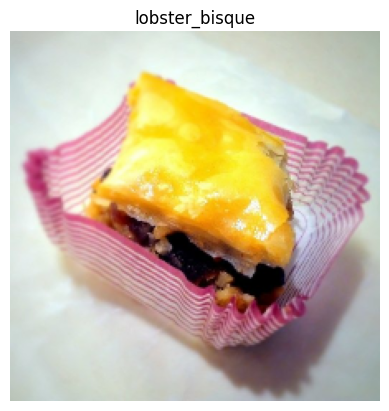

In [52]:
# Plot the pridected class images
pizza_path = '/content/101_food_classes_10_percent/test/baklava/1028777.jpg'
# get the raw image
raw_img = tf.io.read_file(pizza_path)
# decode the raw image data
image_data = tf.io.decode_image(raw_img, 3)
# Resize the image to make sure it hase the same shape as trained image
image_resized = tf.image.resize(image_data, IMAGE_SIZE)
# Rescale the image since the trained images are rescaled
img = image_resized/255.
# pridect the image
uploaded_image_pred = loaded_model.predict(tf.expand_dims(img, axis=0))
# Get the predicted image index
img_pred_index = tf.math.argmax(uploaded_image_pred, axis=1)
# Get the class of pridected image
pridected_image_class = class_names[img_pred_index[0]]
# plot the image
plt.imshow(img)
plt.title(pridected_image_class)
plt.axis(False)

In [38]:
pridected_image_class

np.str_('lobster_bisque')

In [65]:
# Image shape befoer and after reshape
image_data.shape, image_resized.shape

(TensorShape([5472, 3648, 3]), TensorShape([224, 224, 3]))